LTSM Model - Long Short-Term Memory is a recurrent neural networks model for mutiple input varialbes.


1. Import required libraries and base data. Convert data to supervised learning.

In [1]:
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
import pandas as pd
from keras.layers import LSTM,Dropout,Dense
import numpy as np
from statsmodels.tsa.stattools import acf

from numpy.random import seed
seed(1)
 
# convert data to supervised learning
def data_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 
# load dataset
dataset = read_csv('final_dt.csv', header=0, index_col=0)
values = dataset.values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = data_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict (Taking only 1 column 'Close' as the predict column)
reframed.drop(reframed.columns[[11,12,13,14,15,16,17,18,19]], axis=1, inplace=True)
print(reframed.head())

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.046224   0.044550   0.044413   0.041528   0.029638   0.043390   
2   0.047042   0.044888   0.044355   0.041570   0.029734   0.043239   
3   0.047644   0.045252   0.044316   0.041608   0.029856   0.043092   
4   0.045000   0.045257   0.044258   0.041621   0.029958   0.042967   
5   0.044163   0.045090   0.044186   0.041625   0.030044   0.042840   

   var7(t-1)  var8(t-1)  var9(t-1)  var10(t-1)   var1(t)  
1        0.0   0.000000   0.006094    0.780488  0.047042  
2        0.0   0.000280   0.006669    0.780488  0.047644  
3        0.0   0.000373   0.006861    0.780488  0.045000  
4        0.0   0.000466   0.007053    0.780488  0.044163  
5        0.0   0.000559   0.007244    0.780488  0.044795  


2. Check the length of the data to determine train and test data points. Here we have 10298 records. The train and test split will be based on December 2021 dates.

In [12]:
len(dataset)

10298

3. Transform Data for LSTM model - split the data into train and test dataset and reshape the input and out variable to 3D [samples, timestamps, features]

In [2]:
# split into train and test sets
values = reframed.values
train = values[:10275, :]
test = values[10276:, :]
test_forecast=dataset[(dataset.index.get_level_values(0) > "2021-11-30")]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timestamps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(10275, 1, 10) (10275,) (21, 1, 10) (21,)


4. Define Model - LSTM model requires data analyst to determine the number of neurons in the first hidden layer and the number of neuron in the output layer for predicting the interested variable. The Mean Absolute Error loss function will be shown after fitting the model.  


5. Fit Model - The model will be fit for 50 training epochs with a batch size of 72.The MAE cnoverges after 12 epoches.

Epoch 1/50
143/143 - 8s - loss: 0.0320 - val_loss: 0.0207 - 8s/epoch - 58ms/step
Epoch 2/50
143/143 - 1s - loss: 0.0345 - val_loss: 0.0133 - 965ms/epoch - 7ms/step
Epoch 3/50
143/143 - 1s - loss: 0.0171 - val_loss: 0.0290 - 804ms/epoch - 6ms/step
Epoch 4/50
143/143 - 1s - loss: 0.0202 - val_loss: 0.0279 - 505ms/epoch - 4ms/step
Epoch 5/50
143/143 - 0s - loss: 0.0167 - val_loss: 0.0285 - 381ms/epoch - 3ms/step
Epoch 6/50
143/143 - 0s - loss: 0.0150 - val_loss: 0.0207 - 377ms/epoch - 3ms/step
Epoch 7/50
143/143 - 0s - loss: 0.0145 - val_loss: 0.0216 - 362ms/epoch - 3ms/step
Epoch 8/50
143/143 - 0s - loss: 0.0126 - val_loss: 0.0206 - 391ms/epoch - 3ms/step
Epoch 9/50
143/143 - 0s - loss: 0.0139 - val_loss: 0.0189 - 346ms/epoch - 2ms/step
Epoch 10/50
143/143 - 0s - loss: 0.0127 - val_loss: 0.0154 - 375ms/epoch - 3ms/step
Epoch 11/50
143/143 - 0s - loss: 0.0129 - val_loss: 0.0158 - 370ms/epoch - 3ms/step
Epoch 12/50
143/143 - 0s - loss: 0.0129 - val_loss: 0.0133 - 343ms/epoch - 2ms/step
Epo

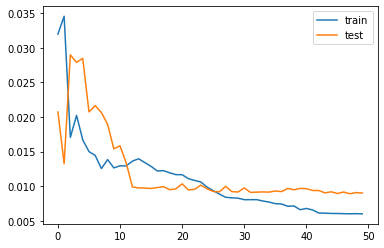

In [3]:
#design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

6. Forecast the test dataset dates. Concatenate the test and predict data and inverse scaling the 'Close' values.

In [4]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

7. Add the predicted values into a dataframe to prepare for graphing.

In [5]:
forecast_df = []
forecast_df = pd.DataFrame(inv_yhat[0:21],index = test_forecast.index,columns=['Prediction'])

8. Shows the final result of the predicted value along with real value of Close price on the same graph.

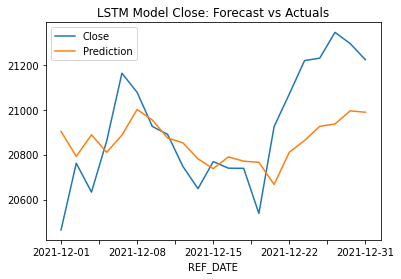

In [6]:
pd.concat([test_forecast['Close'],forecast_df],axis=1).plot(legend=True,title='LSTM Model Close: Forecast vs Actuals')

In [7]:
#Evaluate Forecast
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    return({'mape':mape, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'corr':corr})

print('Forecast Accuracy of: Close')
accuracy_prod = forecast_accuracy(forecast_df['Prediction'].values, test_forecast['Close'].values)
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))



Forecast Accuracy of: Close
mape :  0.0088
mae :  184.1763
mpe :  -0.0028
rmse :  228.0497
corr :  0.5361


9. Final Evaluation of the Model

MAPE: Mean Absolute Percentage Error

MAE: Mean Absolute Error

MPE: Mean Percenage Error

RMSE: Root Mean Square Error

CORR: Correlation Coefficent

Coefficient, r

Strength of Association	Positive	Negative

Small	                 .1 to .3 or	-0.1 to -0.3

Medium	               .3 to .5 or	-0.3 to -0.5

Large	                 .5 to 1.0 or	-0.5 to -1.0